# Содержание
1.  Описание задачи
2.  Загрузка данных
3.  Умножение матриц
4. Алгоритм преобразования
5. Проверка алгоритма
6. Выводы

# Защита персональных данных клиентов
## Описание задачи

Вам нужно защитить данные клиентов страховой компании. Разработайте такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию. Обоснуйте корректность его работы.

Нужно защитить данные, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. Подбирать наилучшую модель не требуется.

### Для достижения целей необходимо решить следующие задачи:
- Изменится ли качество линейной регрессии, если признаки умножают на обратимую матрицу? (Её можно обучить заново.)

a. Изменится. Приведите примеры матриц.

b. Не изменится. 
- Указать, как связаны параметры линейной регрессии в исходной задаче и в преобразованной.

- Предложите алгоритм преобразования данных для решения задачи. 
- Обоснуйте, почему качество линейной регрессии не поменяется.
- Запрограммируйте этот алгоритм, применив матричные операции. 
- Проверьте, что качество линейной регрессии из sklearn не отличается до и после преобразования. Примените метрику R2.

## Загрузка данных

Импортируем библиотеки

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

Загрузим файл

In [2]:
df = pd.read_csv('/datasets/insurance.csv')

Вывдем информацию о файле и первые строки

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
Пол                  5000 non-null int64
Возраст              5000 non-null float64
Зарплата             5000 non-null float64
Члены семьи          5000 non-null int64
Страховые выплаты    5000 non-null int64
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


Пропусков нет, количество записей - 5000

Согласно описанию, в таблице следующая информация:

пол, возраст и зарплата застрахованного, количество членов его семьи.
Целевой признак: количество страховых выплат клиенту за последние 5 лет.

In [4]:
df.head()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


In [5]:
df.nunique()

Пол                    2
Возраст               46
Зарплата             524
Члены семьи            7
Страховые выплаты      6
dtype: int64

In [6]:
df.describe()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


Отрицательных значений нет, что хорошо. Практически равное рапределение по полам. Возраст от 18 лет. Минимальная зарплата 5300. Максимальное к-во членов семьи - 6.
Максимальное к-во страховых выплат за 5 лет - 5. Среднее значение страховых выплат очень мало, что говорит о том, что в датасете преобладают нулевые значения - отсутствие выплат

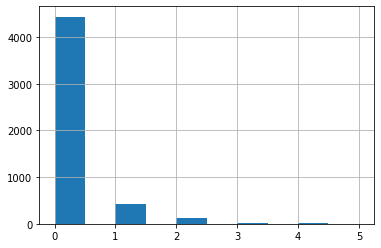

In [7]:
df['Страховые выплаты'].hist()

In [8]:
(df['Страховые выплаты']==0).sum()

4436

Для удобства работы переименуем столбцы

In [9]:
df = df.rename({'Пол':'sex','Возраст':'age','Зарплата':'salary', 'Члены семьи':'family_members','Страховые выплаты':'payments'}, axis = 1)

In [10]:
df.head()

,sex,age,salary,family_members,payments
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


Так как в задании не требуется, то не проверяем на наличие дубликатов. Дубликаты могут присутствовать - но это не говорит о том, что это не могут быть разные люди.

### Выводы

Файл открылся без проблем. Содержания столбцов соответствует описанию. Записей - 5000, пропусков нет. Столбцы переименовали используя *snake_case*. В таблице указано 5 признаков, из которых целевой признак только один -  `payments`. Наблюдается дисбаланс - у целевого признака количество 0 значительно превышает к-во других значений.

## Умножение матриц

Изменится ли качество линейной регрессии, если признаки умножают на обратимую матрицу?

**Ответ** - не изменится
 

**Обоснование**. Для обоснования воспользуемся следующими обозначениями:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = Xw
$$

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

Для доказательства утверждения необходимо показать, что результат предсказания линейной регрессии будет иметь одинаковые значения для исходной матрицы признаков и для матрицы признаков, умноженной на обратимую матрицу. Для доказательства воспользуемся некоторыми свойствами матриц:

$$ 
(AB)^{-1} = B^{-1}A^{-1}
$$

$$
(AB)^T = B^TA^T
$$

$$
AA^{-1}=E
$$

Покажем, чему будут равны предсказания регрессии, если вместо $X$ будем использовать $XP$:

$$
a'=XPw'=XP((XP)^T XP)^{-1} (XP)^T y
$$

Воспользововшись свойством транспонирования матриц получим:

$$
XP((XP)^T XP)^{-1} (XP)^T y = XP(P^T X^T X P)^{-1} P^T X^T y
$$

Для нахождения обратных матриц, перегруппируем множители, воспользовавшись свойством $(AB)C=A(BC)$ чтобы получить квадратные матрицы. Учитываем, что $P$-обратимая матрица, а значит квадратная
$$
XP(P^T X^T X P)^{-1} P^T X^T y = XP[(P^T) (X^T X P)]^{-1} P^T X^T y
$$

Далее воспользуемся свойством обратной матрицы, получим:

$$
XP[(P^T X^T X) (P)]^{-1} P^T X^T y = XP(X^T X P)^{-1} (P^T)^{-1} P^T X^T y  = 
XP P^{-1} (X^T X)^{-1} (P^T)^{-1} P^T X^T y
$$

Учитывая, что $P P^{-1} = (P^T)^{-1} P^T=E$, получим

$$
XPP^{-1} (X^T X)^{-1} (P^T)^{-1} P^T X^T y = XPP^{-1} (X^T X)^{-1} X^T y=X (X^T X)^{-1}X^T y = Xw = a
$$

$$
a'=a
$$

Таким образом предсказания линейной регрессии не зависят от того, умножаются ли признаки на обратимую матрицу или нет. А если не изменяются предсказания, то и качество регрессии не зависит.

Из последней формулы можем получить соотношения весов линейной регрессии для исходных признаков $w$ и преобразованных $w'$

$$
a'=a=>Xw=XPw'=>w=Pw'=>w'=P^{-1}w
$$

### Выводы. 
Качество линейной регрессии не зависит от умножения признаков на обратимую матрицу. Соотношение весов для преобразованной и непреобразованной матрицы определяется выражением $w'=P^{-1}w$

## Алгоритм преобразования

**Алгоритм**
Для защиты персональных данных воспользуемся свойством из предыдущего пункта. Для того, чтобы хранимые данные были защищены, достаточно признаки умножить на обратимую случайную матрицу. Причём для корректности прогнозов даже 

**Обоснование**
Если персональные данные умножить на случайную обратимую матрицу, то это скроет данные, но в то же время прогноз линейной регрессии останется без изменений. 

## Проверка алгоритма

Разделим данные на `features` и `target`

In [11]:
features = df.drop('payments', axis=1)

In [12]:
target = df['payments']

Определим размер матрицы $P$

In [13]:
size = features.shape[1]

In [32]:
size

4

Определим функцию, которая будет возвращать матрицу $P$ случайным образом. В функции проверим, чтобы матрица имела обратную - т.е. её определитель не был равен нулю.

In [16]:
def fun_p(size):
    while True:
        p=np.random.rand(size,size)
        if np.linalg.det(p)!=0:
            return p

In [19]:
p=fun_p(size)
p

array([[0.98635196, 0.78751979, 0.09556395, 0.84682467],
       [0.60933555, 0.86768214, 0.15604151, 0.71444855],
       [0.40296911, 0.56781455, 0.69895871, 0.34962554],
       [0.21025649, 0.89890051, 0.9995602 , 0.03227306]])

Создадим и обучим модель линейной регрессии

In [20]:
model=LinearRegression()
model.fit(features,target)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Получим значения коэффициентов модели

In [21]:
model.coef_

array([ 7.92580543e-03,  3.57083050e-02, -1.70080492e-07, -1.35676623e-02])

Определим R2-метрику модели. Для линейной регрессии эта метрика определяется методом `score`.

In [22]:
model.score(features,target)

0.42494550286668

Теперь создадим новые признаки, умножив их значения на матрицу $P$

In [23]:
features_hided = features.values @ p

Создадим новую модель линейной регресии

In [24]:
model_hided = LinearRegression()

Обучим её на скрытых данных

In [25]:
model_hided.fit(features_hided,target)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Посмотрим на R2-метрику

In [26]:
model_hided.score(features_hided,target)

0.42494550286666644

Метрики для скрытых и нескрытых данных практически одинаковы. Проверим утверждения о зависимости параметров линейной регрессии $Pw'=w$

In [27]:
p @ model_hided.coef_

array([ 7.92580543e-03,  3.57083050e-02, -1.70080492e-07, -1.35676623e-02])

In [28]:
model.coef_

array([ 7.92580543e-03,  3.57083050e-02, -1.70080492e-07, -1.35676623e-02])

Видим, что коэффициенты соответствуют утверждению.

## Выводы


В ходе работы теоретически обосновали метод защиты персональных данных и предложили алгоритм преобразования умножением на обратимую случайную матрицу. Теоретические формулировки проверили практически с использованием моделей линейной регрессии. Результаты показали, что метрика R2 для моделей, обученных на скрытых и исходных данных одинаковы, что позволяет говорит о том, что метод умножения на обратимую матрицу не изменяет точность предсказания линейной регрессии.